## Training of GAiA's neural network

In [1]:
from model.GAiA_network import GAiA_Network, MAE, coefficient_determination
from lib.dataset_utils import read_many_hdf5, board_shape
from lib.torch_model_wrapper import TorchWrapper

import pickle
import matplotlib.pyplot as plt
import torch

import platform
if platform.system() == "Darwin":
  %config InlineBackend.figure_format="retina"  # For high DPI display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We retrieve the network's optimal hyperparameters from the `choose_hyperparameters` notebook.

In [3]:
input_file = open("saved_models/hyperparameters.pickle", "rb")
hyperparams = pickle.load(input_file)
input_file.close()
print(hyperparams)

{'nb_blocks': 4, 'filters': 64}


We create a network with these hyperparameters.

In [4]:
network = GAiA_Network(board_shape, **hyperparams)
_ = network.to(device)

In [5]:
loss_function = MAE
optimizer = torch.optim.Adam(network.parameters(), lr=0.001, eps=1e-07)

In [6]:
twrapper = TorchWrapper(network, device, optimizer, loss_function, coefficient_determination)
print(f"{twrapper.get_parameters(trainable=True)} trainable parameters.")
twrapper.print_cuda_memory_state()

46161 trainable parameters.
Total mem: 7.79 GiB, Reserved mem: 0.00 GiB, Allocated mem: 0.00 GiB, Free mem: 7.79 GiB


It's time to train! You can take a coffee or two (maybe more).

In [7]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
nb_epochs = 30

history = {"loss": [], "metric": []}

for i, nb_pos in enumerate([992453, 992388, 992346]):
  print(f"Training set {i+1}")
  positions_train, scores_train = read_many_hdf5(nb_pos, directory, "_train")
  scores_train = scores_train.reshape(-1, 1)
  positions_train = positions_train.transpose((0, 3, 1, 2)) # Channel first
  tmp_history = twrapper.fit(positions_train, scores_train, epochs=nb_epochs, batch_size=1024)
  history["loss"] += tmp_history["loss"]
  history["metric"] += tmp_history["metric"]

Training set 1
Epoch: 1 Loss: 355.41 Metric: 0.32
Epoch: 2 Loss: 272.37 Metric: 0.51
Epoch: 3 Loss: 259.99 Metric: 0.52
Epoch: 4 Loss: 243.77 Metric: 0.54
Epoch: 5 Loss: 235.55 Metric: 0.55
Epoch: 6 Loss: 232.58 Metric: 0.55
Epoch: 7 Loss: 229.37 Metric: 0.56
Epoch: 8 Loss: 227.22 Metric: 0.56
Epoch: 9 Loss: 224.61 Metric: 0.58
Epoch: 10 Loss: 209.00 Metric: 0.70
Epoch: 11 Loss: 184.47 Metric: 0.83
Epoch: 12 Loss: 166.68 Metric: 0.90
Epoch: 13 Loss: 162.61 Metric: 0.90
Epoch: 14 Loss: 160.20 Metric: 0.91
Epoch: 15 Loss: 157.90 Metric: 0.91
Epoch: 16 Loss: 157.03 Metric: 0.91
Epoch: 17 Loss: 155.56 Metric: 0.91
Epoch: 18 Loss: 154.25 Metric: 0.91
Epoch: 19 Loss: 153.50 Metric: 0.91
Epoch: 20 Loss: 152.37 Metric: 0.91
Epoch: 21 Loss: 151.22 Metric: 0.91
Epoch: 22 Loss: 150.65 Metric: 0.91
Epoch: 23 Loss: 150.12 Metric: 0.91
Epoch: 24 Loss: 149.67 Metric: 0.91
Epoch: 25 Loss: 148.82 Metric: 0.91
Epoch: 26 Loss: 148.18 Metric: 0.92
Epoch: 27 Loss: 147.39 Metric: 0.92
Epoch: 28 Loss: 147.87

We save the network.

In [8]:
twrapper.save("saved_models/GAiA_Network.pth")

We convert the network to onnx format so that the engine can use it.

In [9]:
dummy_input = torch.rand((1, *board_shape)).to(device)
torch.onnx.export(
  network,
  dummy_input,
  "../Engine/build/network.onnx",
  verbose=False,
  input_names=["input"],
  output_names=["output"])

In [10]:
def plot_history(history, path=None):
  epochs = range(1, len(history["loss"]) + 1)

  _, axs = plt.subplots(1, 2, figsize=(20, 5))
  loss = history["loss"]
  score = history["metric"]

  axs[0].plot(epochs, loss, "r-.")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Mean Squared Error")
  axs[0].set_title("Training loss")

  axs[1].plot(epochs, score, "g-.")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("$R^2$")
  axs[1].set_title("Training score")
  
  if path:
    plt.savefig(path)

We plot the loss and accuracy of each epoch.

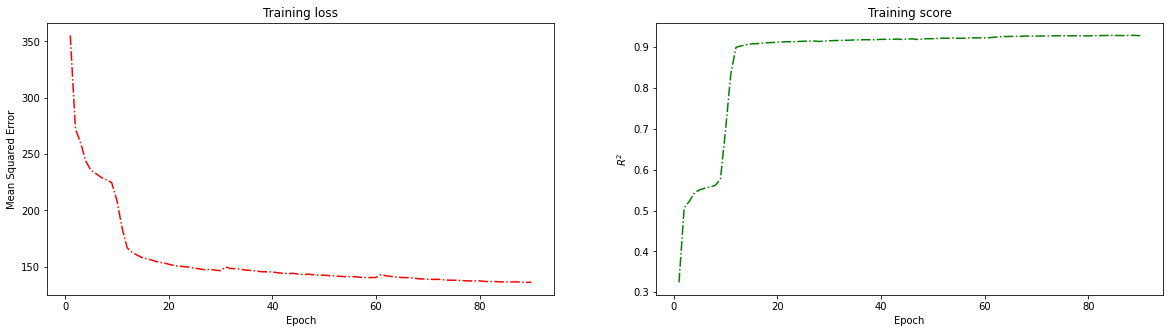

In [11]:
plot_history(history, path="results/GAiA_history2.pdf")